# Import data

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from caltech256 import Caltech256
import torchvision.models as models

#import data

example_transform = transforms.Compose(
    [
        transforms.Scale((224,224)),
        transforms.ToTensor(),
    ]
)
        
caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
caltech256_test = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=False)

train_data = torch.utils.data.DataLoader(
    dataset = caltech256_train,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
)

test_data = torch.utils.data.DataLoader(
    dataset = caltech256_test,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
)

# print(train_data)

#import vgg model

vgg16 = models.vgg16(pretrained = True)
# print(vgg16)








# define model based on VGG16

In [2]:
#replace layer 


class Diy_vgg(nn.Module):
    def __init__(self):
        super(Diy_vgg,self).__init__()
        self.features = vgg16.features
        self.classifier = nn.Sequential(
            nn.Linear(25088,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,256)
    )
    def forward(self,x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return out


#make instance        
diy_model = Diy_vgg()
#close autograd


    

In [3]:
print(diy_model)

Diy_vgg (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)

In [3]:
#only softmax can be update

for param in diy_model.parameters():
    param.requires_grad = False
diy_model.classifier[6].weight.requires_grad = True
diy_model.classifier[6].bias.requires_grad = True
# for param in diy_model.parameters():
#     print(param.requires_grad)


In [ ]:
dir(train_data.dataset)

In [4]:
def testing(net = None, data_to_test = None):
    # Test the Model
    net.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
    net.cuda()
    correct = 0
    total = 0
    for images, labels in data_to_test:
        images = Variable(images).cuda()
        labels = labels.long()
        labels = labels.view(labels.size()[0])
        labels = labels - 1
#         labels = Variable(labels).cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    return 100 * correct / total
    

In [6]:
testing(net = diy_model,data_to_test = test_data)

0.390625

# train model

In [6]:





#train

#
learning_rate = 0.0001
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(diy_model.classifier[6].parameters(),lr = learning_rate)

diy_model.cuda()
#diy_model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_data):
        labels = labels.long()
        labels = labels.view(labels.size()[0])
        labels = labels - 1
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        outputs = diy_model(images)
        train_loss = criterion(outputs,labels)
        train_loss.backward()
        optimizer.step()
        if i % 200 ==0:
            print("epoch[%d]\tLoss:%s\tAcc:%s"%(epoch,train_loss.data[0],testing(net = diy_model,data_to_test = test_data)))




epoch[0]	Loss:5.569393157958984	Acc:0.29296875
epoch[0]	Loss:5.405646324157715	Acc:6.0546875
epoch[1]	Loss:5.179218292236328	Acc:16.69921875


Process Process-13:
Process Process-14:
Process Process-15:
Process Process-16:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", 

KeyboardInterrupt: 

In [13]:
images.numpy()

array([[[[ 0.36470589,  0.36862746,  0.36862746, ...,  0.24705882,
           0.24313726,  0.23529412],
         [ 0.36470589,  0.36862746,  0.36862746, ...,  0.25098041,
           0.24705882,  0.23921569],
         [ 0.36078432,  0.36470589,  0.36470589, ...,  0.25490198,
           0.25490198,  0.24313726],
         ..., 
         [ 0.02745098,  0.04313726,  0.05490196, ...,  0.04705882,
           0.05098039,  0.04313726],
         [ 0.01568628,  0.01568628,  0.01176471, ...,  0.02352941,
           0.02352941,  0.02352941],
         [ 0.00392157,  0.        ,  0.00392157, ...,  0.00392157,
           0.        ,  0.        ]],

        [[ 0.54901963,  0.5529412 ,  0.5529412 , ...,  0.45882353,
           0.45490196,  0.44705883],
         [ 0.54901963,  0.5529412 ,  0.54901963, ...,  0.4627451 ,
           0.45882353,  0.4509804 ],
         [ 0.54509807,  0.54901963,  0.54901963, ...,  0.46666667,
           0.46666667,  0.45490196],
         ..., 
         [ 0.02745098,  0.043137

# first conv layer result 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
#visualize from firt convolution filters

# images = images.data.cpu()
#show original picture
pic = np.zeros((224,224,3))
pic[:,:,0] = images[2][0,:,:].numpy()
pic[:,:,1] = images[2][1,:,:].numpy()
pic[:,:,2] = images[2][2,:,:].numpy()
# plt.figure
# plt.imshow(pic)
# plt.show()

first_conv = diy_model.features[0].cpu()
new_pic = torch.zeros(1,3,224,224)
new_pic[0,:,:,:] = images[3]
conv_result = first_conv(Variable(new_pic))







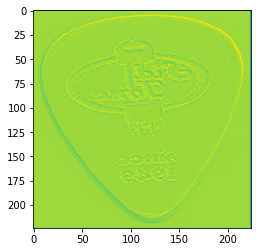

In [15]:
plt.imshow(conv_result[0][2].data.numpy())
plt.show()



# first layer filter visulization

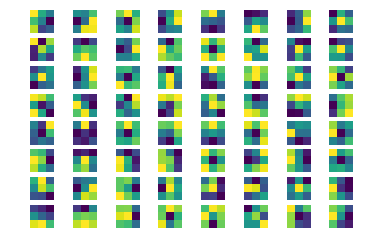

In [14]:
#show weights
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(first_conv.weight[i][1].data.numpy())
    plt.axis('off')
plt.show()


In [24]:
to_last_conv = nn.Sequential()
for i in range(30):
#     print("%d:"%i,diy_model.features[i])
    to_last_conv.add_module(str(i),diy_model.features[i])

# result from last conv layer
to_last_conv.cuda()
to_last_conv_result = to_last_conv(Variable(new_pic).cuda())


In [22]:
to_last_conv

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): Conv2d(512,

# Last filter results

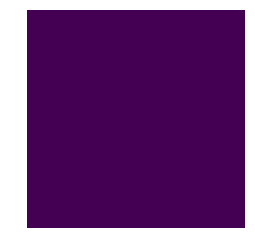

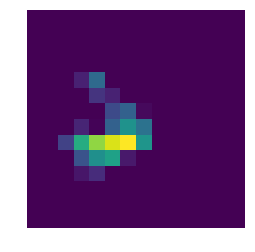

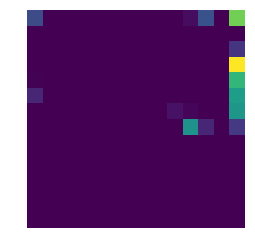

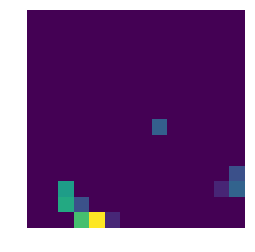

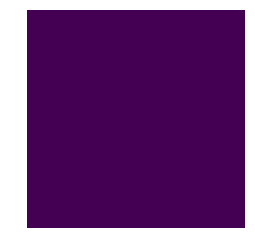

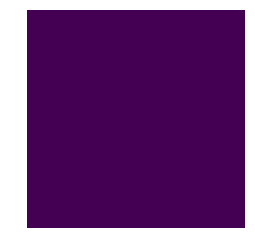

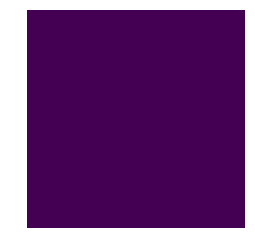

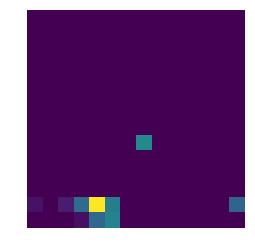

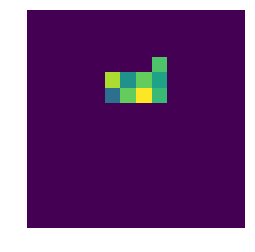

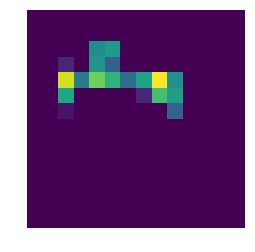

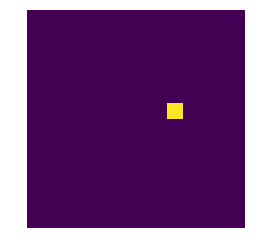

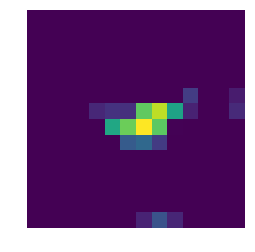

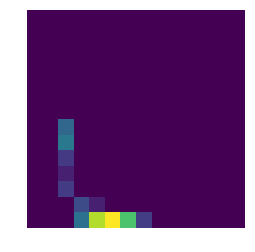

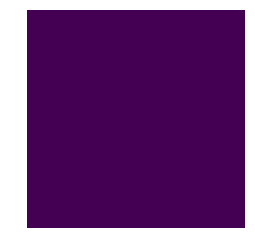

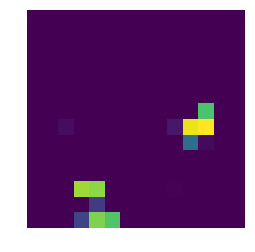

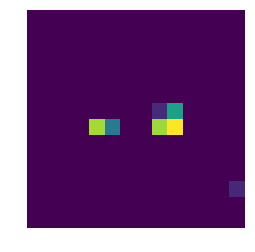

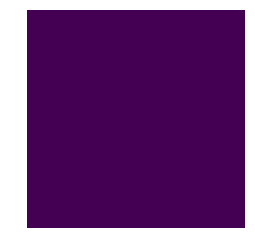

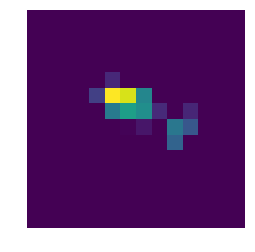

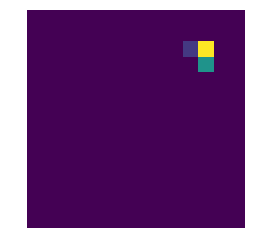

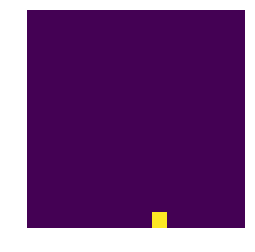

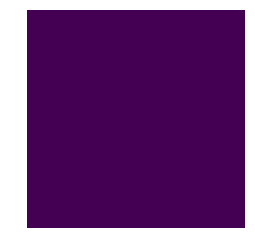

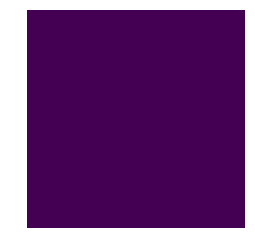

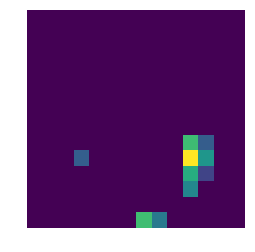

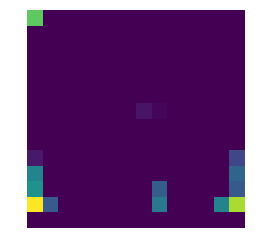

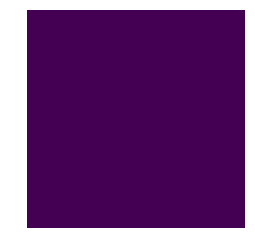

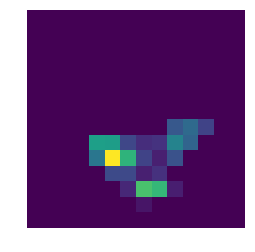

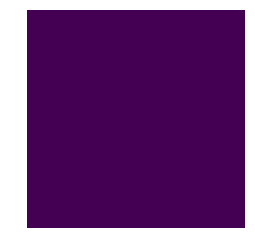

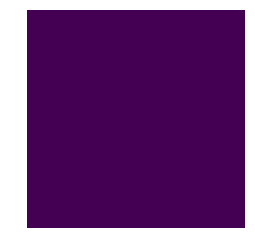

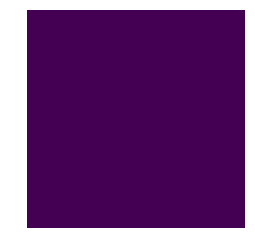

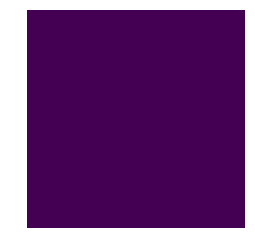

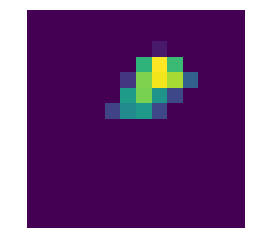

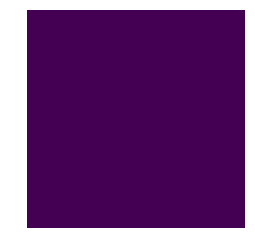

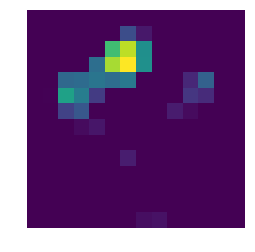

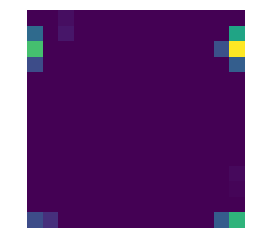

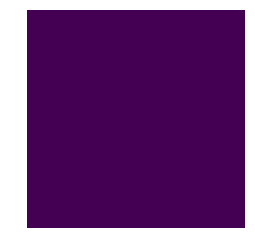

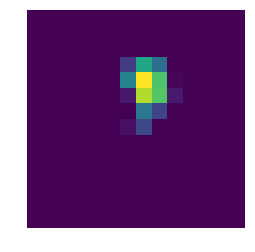

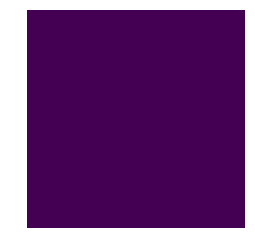

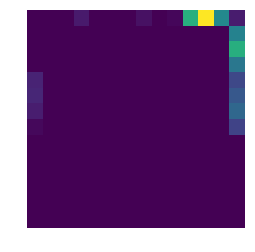

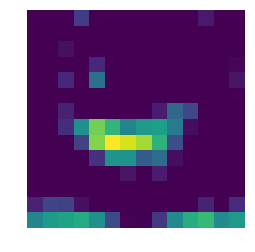

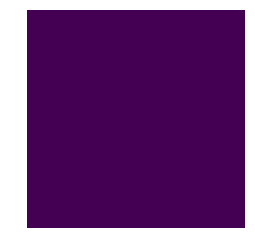

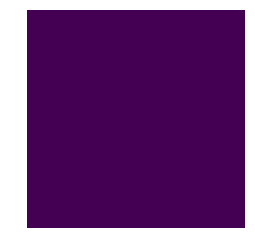

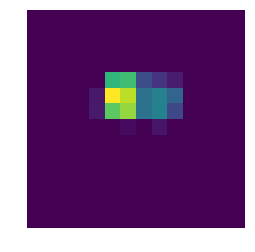

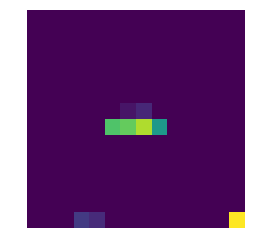

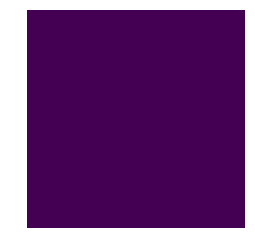

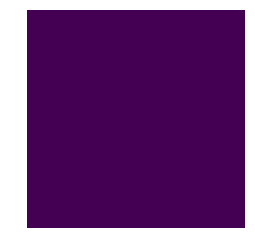

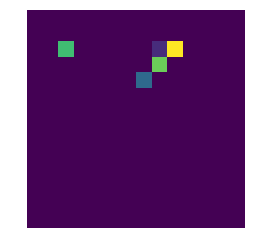

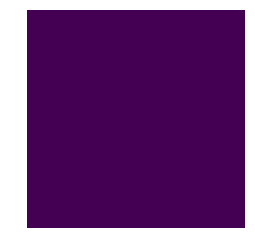

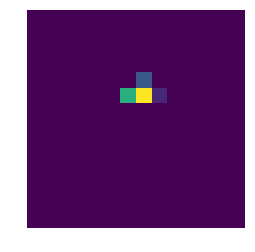

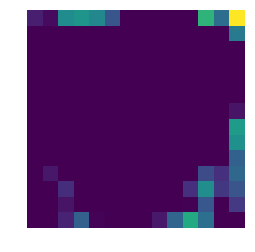

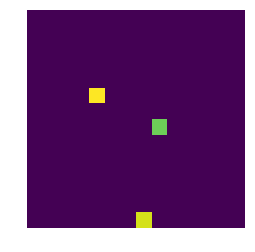

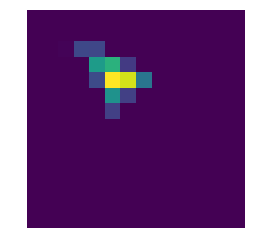

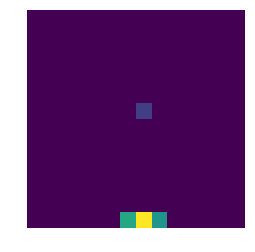

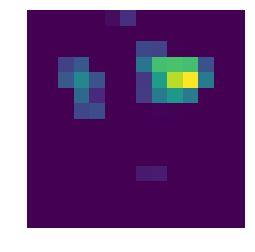

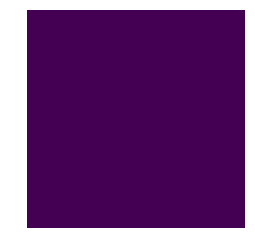

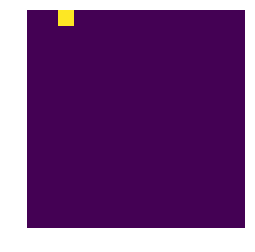

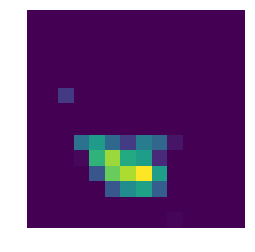

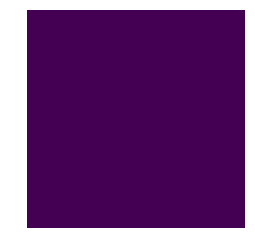

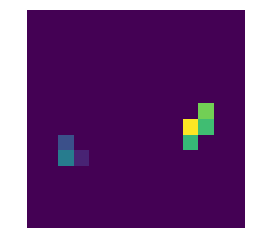

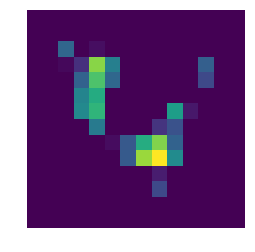

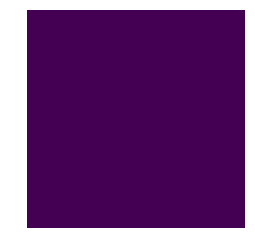

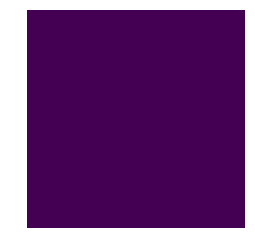

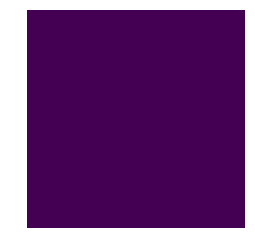

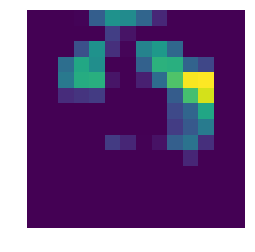

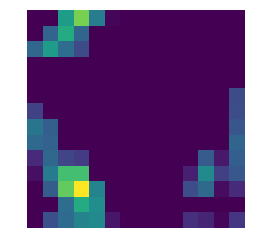

In [32]:
for i in range(64):
#     plt.subplot(8,8,i+1)
    plt.imshow(to_last_conv_result[0][i].data.cpu().numpy())
    plt.axis('off')
    plt.show()
plt.show()

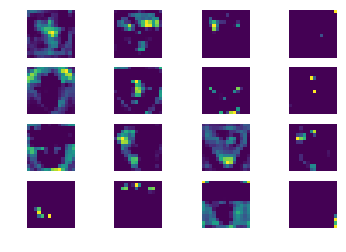

In [33]:
to_second_conv = nn.Sequential()
for i in range(26):
#     print("%d:"%i,diy_model.features[i])
    to_second_conv.add_module(str(i),diy_model.features[i])

# result from last conv layer
to_second_conv.cuda()
to_second_conv_result = to_second_conv(Variable(new_pic).cuda())

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(to_second_conv_result[0][i].data.cpu().numpy())
    plt.axis('off')
plt.show()




# feature extraction 

In [ ]:
labels

In [ ]:
print(vgg16)

In [ ]:
# # plt.imshow(first_batch[0].numpy()[0])
# # plt.show()
# pic = np.zeros((224,224,3))
# # [pic[:,:,x] = first_batch[0].numpy()[0][x]) for x in range(3)]
# pic[:,:,0] = first_batch[0].numpy()[1][0]
# pic[:,:,1] = first_batch[0].numpy()[1][1]
# pic[:,:,2] = first_batch[0].numpy()[1][2]
# plt.imshow(pic)
# plt.show()